# Imports

In [16]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


# Visualize Utilities

In [17]:
im_width = 75
im_height = 75
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image, #numpy array object
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()
                                       ):
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new('RGBA', image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)

  return np.array(rgbimg)

def draw_bounding_boxes_on_image(image, #PIL image object
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be size of [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i,0], boxes[i, 3], boxes[i, 2]
                               , color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color='red',
                               thickness=1, display_str=None,
                               use_normalized_coordinates=True):
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)

In [18]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)

  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break

  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)

  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (75*n, 75), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*75,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75*n]), n, axis=1), axis=0), [n, 75*75])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_labels = labels[indexes]

  n_iou = []
  if len(iou) > 0:
    n_iou = iou[indexes]

  if (len(pred_bboxes) > 0):
    n_pred_bboxes = pred_bboxes[indexes,:]

  if (len(bboxes) > 0):
    n_bboxes = bboxes[indexes,:]


  n_digits = n_digits * 255.0
  n_digits = n_digits.reshape(n, 75, 75)
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    bboxes_to_plot = []
    if (len(pred_bboxes) > i):
      bboxes_to_plot.append(n_pred_bboxes[i])

    if (len(bboxes) > i):
      bboxes_to_plot.append(n_bboxes[i])

    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=np.asarray(bboxes_to_plot), color=['red', 'green'], display_str_list=["true", "pred"])
    plt.xlabel(n_predictions[i])
    plt.xticks([])
    plt.yticks([])

    if n_predictions[i] != n_labels[i]:
      ax.xaxis.label.set_color('red')



    plt.imshow(img_to_draw)

    if len(iou) > i :
      color = "black"
      if (n_iou[i][0] < iou_threshold):
        color = "red"
      ax.text(0.2, -0.3, "iou: %s" %(n_iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

# TPU or GPU Detection

In [19]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices('GPU')

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [20]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

# Load and Preprocess Data

In [21]:
def read_image_tfds(image, label):
  xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  image = tf.reshape(image, (28, 28, 1))
  image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
  image = tf.cast(image, tf.float32)
  xmin = tf.cast(xmin, tf.float32)
  ymin = tf.cast(ymin, tf.float32)

  xmax = (xmin + 28) / 75
  ymax = (ymin + 28) / 75
  xmin = xmin / 75
  ymin = ymin / 75
  return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

def get_training_dataset():
  with strategy.scope():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
  return dataset

def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

# Visualize Data

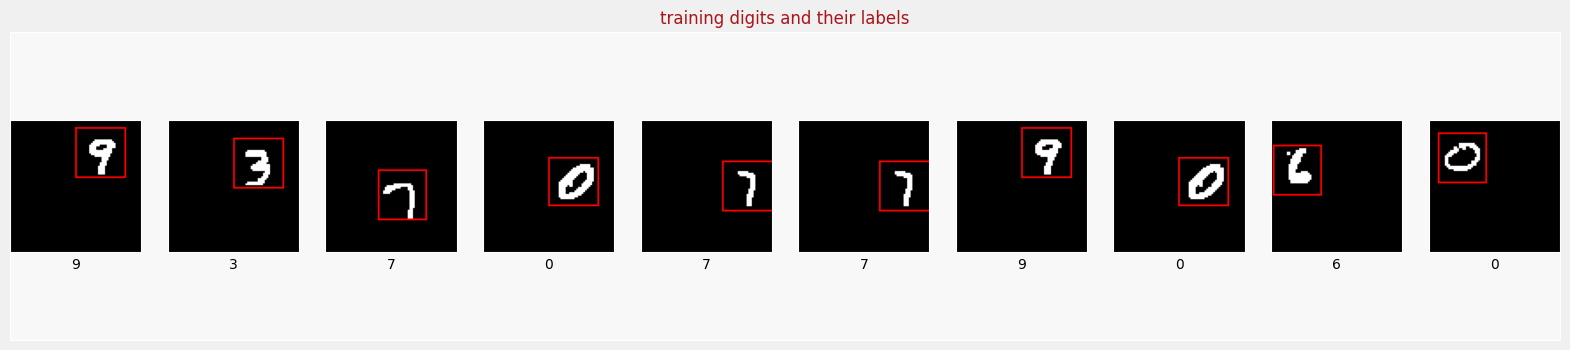

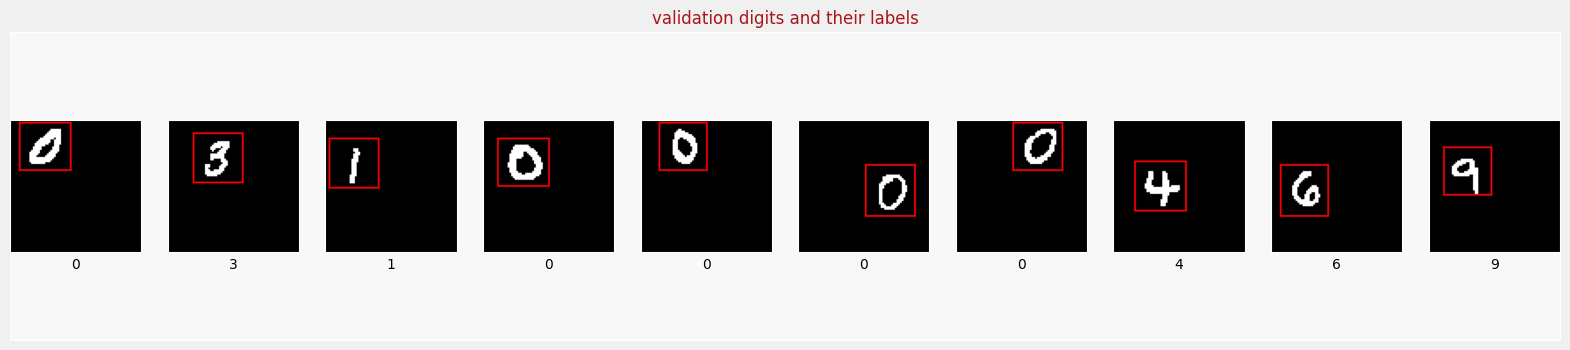

In [22]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

display_digits_with_boxes(training_digits, training_labels, training_labels, np.array([]), training_bboxes, np.array([]), "training digits and their labels")
display_digits_with_boxes(validation_digits, validation_labels, validation_labels, np.array([]), validation_bboxes, np.array([]), "validation digits and their labels")

# Define the Network

In [23]:
def feature_extractor(inputs):
  x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(75,75))(inputs)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
  x = tf.keras.layers.AveragePooling2D((2,2))(x)

  return x

def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)

  return x

def classifier(inputs):
  return tf.keras.layers.Dense(10, activation='softmax',
                               name='classification')(inputs)

def bounding_box_regression(inputs):
  return tf.keras.layers.Dense(4, name='bounding_box')(inputs)

def final_model(inputs):
  cnn = feature_extractor(inputs)
  dense = dense_layers(cnn)

  classification_output = classifier(dense)
  bounding_box = bounding_box_regression(dense)

  model = tf.keras.Model(inputs=inputs, outputs=[classification_output,
                                                 bounding_box])
  return model

def define_and_compile_model(inputs):
  model = final_model(inputs)

  model.compile(optimizer='adam',
                loss={
                    'classification': 'categorical_crossentropy',
                    'bounding_box': 'mse'
                },
                metrics={
                    'classification': 'accuracy',
                    'bounding_box': 'mse'
                })
  return model

with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1))
  model = define_and_compile_model(inputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 73, 73, 16)   160         ['input_2[0][0]']                
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 36, 36, 16)  0           ['conv2d_3[0][0]']               
 oling2D)                                                                                         
                                                                                                  
 conv2d_4 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d_3[0][0]

# Train and validate the model

In [24]:
EPOCHS = 10
steps_per_epoch = 60000//BATCH_SIZE
validation_steps = 1

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset, validation_steps=validation_steps,
                    epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
937/937 [==============================] - 21s 18ms/step - loss: 0.6945 - classification_loss: 0.6282 - bounding_box_loss: 0.0664 - classification_accuracy: 0.7884 - bounding_box_mse: 0.0664 - val_loss: 0.2147 - val_classification_loss: 0.1910 - val_bounding_box_loss: 0.0237 - val_classification_accuracy: 0.9427 - val_bounding_box_mse: 0.0237
Epoch 2/10
937/937 [==============================] - 13s 14ms/step - loss: 0.1477 - classification_loss: 0.1323 - bounding_box_loss: 0.0155 - classification_accuracy: 0.9602 - bounding_box_mse: 0.0155 - val_loss: 0.1048 - val_classification_loss: 0.0948 - val_bounding_box_loss: 0.0100 - val_classification_accuracy: 0.9695 - val_bounding_box_mse: 0.0100
Epoch 3/10
937/937 [==============================] - 12s 13ms/step - loss: 0.1063 - classification_loss: 0.0989 - bounding_box_loss: 0.0073 - classification_accuracy: 0.9689 - bounding_box_mse: 0.0073 - val_loss: 0.0983 - val_classification_loss: 0.0927 - val_bounding_box_loss: 0.0057 -

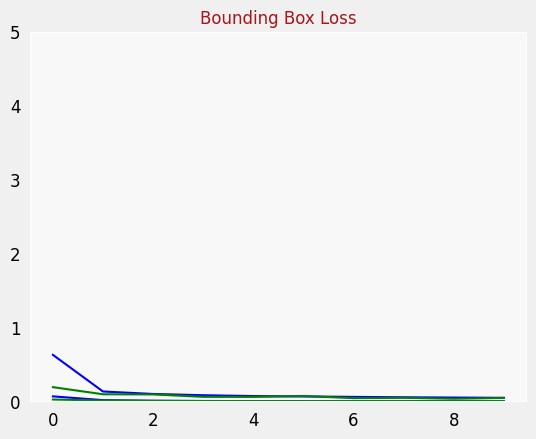

In [25]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")

# IOU

In [26]:
def intersection_over_union(pred_box, true_box):
  xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
  xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

  smoothing_factor = 1e-10

  xmin_overlap = np.maximum(xmin_pred, xmin_true)
  xmax_overlap = np.maximum(xmax_pred, xmax_true)
  ymin_overlap = np.maximum(ymin_pred, ymin_true)
  ymax_overlap = np.maximum(ymax_pred, ymax_true)

  pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
  true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

  overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
  union_area = (pred_box_area + true_box_area) - overlap_area

  iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

  return iou

157/157 [==============================] - 0s 2ms/step
Number of predictions where iou > threshold(0.6): 10000
Number of predictions where iou < threshold(0.6): 0


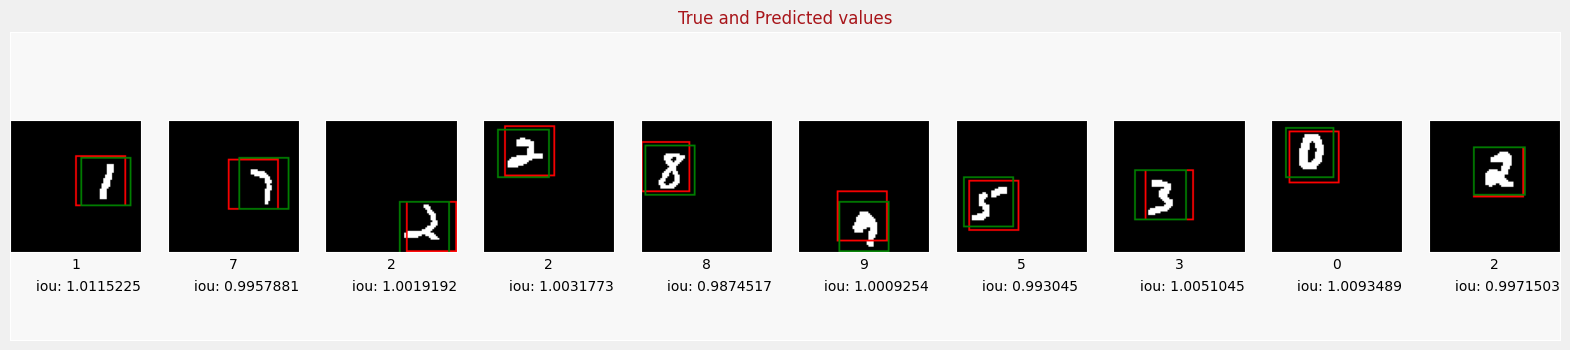

In [27]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")